In [1]:
import Locate_Ice_Mosaic
from importlib import reload
reload(Locate_Ice_Mosaic)
from Locate_Ice_Mosaic import M3_Mosaic
from os import path as path
import os
import tifffile as tf

ice_pipe_folder = 'D:/Data/Ice_Pipeline_Out_6-14-23'
smooth_folder = path.join(ice_pipe_folder,'rfl_smooth_normalized')

def find(s,c):
    return [n for n,i in enumerate(s) if i==c]

in_dict = {}
prog,tot = 1,len(os.listdir(smooth_folder))
for file in os.listdir(smooth_folder):
    im = tf.imread(path.join(smooth_folder,file))
    in_dict.update({file[:find(file,'_')[0]]:im})
    print (f'\r{prog} of {tot} ({prog/tot:.1%})',end='\r')
    prog+=1

In [3]:
rfl_smooth_norm = tf.imread('D:/Data/Ice_Pipeline_Out_6-14-23/rfl_smooth_normalized/20090528t083319_smooth_normalized.tif')
print (rfl_smooth_norm.max())

255.0


In [2]:
from importlib import reload
import Locate_Ice_Mosaic
import os
reload(Locate_Ice_Mosaic)
from Locate_Ice_Mosaic import M3_Mosaic

def load_tifs(pathList:list)->list:
    tif_list = []
    prog,tot = 1,len(pathList)
    for path in pathList:
        if path.find('aux')==-1:
            tif_list.append(tf.imread(path))
        print (f'\r{prog} of {tot} retrived. ({prog/tot:.0%})',end='\r')
        prog+=1
    return tif_list

print ('Select Analysis Folder:')
folderPath = 'D:/Data/Ice_Pipeline_Out_6-14-23'
all_rfl_paths = [os.path.join(folderPath,'rfl_cropped',i) for i in os.listdir(os.path.join(folderPath,'rfl_cropped'))]
all_loc_paths = [os.path.join(folderPath,'loc_cropped',i) for i in os.listdir(os.path.join(folderPath,'loc_cropped'))]
all_obs_paths = [os.path.join(folderPath,'obs_cropped',i) for i in os.listdir(os.path.join(folderPath,'obs_cropped'))]

with open(os.path.join(folderPath,'stampNames.txt')) as f:
    all_names = f.readlines()
all_names = [i[:-2] for i in all_names]

def batch_list(input:list,n:int)->list:
    return [input[i:i+n] for i in range(0,len(input),n)]

N = 5
batch_rfl_paths = batch_list(all_rfl_paths,N)
batch_loc_paths = batch_list(all_loc_paths,N)
batch_obs_paths = batch_list(all_obs_paths,N)
all_names_split = batch_list(all_names,N)
batch_keys = batch_list(tuple(in_dict.keys()),N)
batch_vals = batch_list(tuple(in_dict.values()),N)


prog,tot=0,len(all_rfl_paths)
for n in range(len(batch_rfl_paths)):
    print ('Retrieving RFL Tifs...')
    batch_rfl = load_tifs(batch_rfl_paths[n])
    print ('\nRetrieving LOC Tifs...')
    batch_loc = load_tifs(batch_loc_paths[n])
    print ('\nRetrieving OBS Tifs...')
    batch_obs = load_tifs(batch_obs_paths[n])
    batch_names = all_names_split[n]

    batch_dict = {key:val for key,val in zip(batch_keys[n],batch_vals[n])}
    print(batch_dict.keys())

    batchMosaic = M3_Mosaic(batch_rfl,batch_loc,batch_obs,batch_names,folderPath)
    prog = prog+len(batchMosaic.stampNames)
    print (f'\n-----Beginning Mosaic analysis of {len(batchMosaic.stampNames)} ({prog} of {tot})images-----')
    print ('calculating band depth...')
    band_depth_map,min_position_map = batchMosaic.calculate_band_depth(inputImageDictionary=batch_dict)
    #allband_array = batchMosaic.locate_ice(inputImageDictionary=batch_dict)

    print ('\nRemoval from memory...')
    del batch_rfl,batch_loc,batch_obs

Select Analysis Folder:
Retrieving RFL Tifs...
5 of 5 retrived. (100%)
Retrieving LOC Tifs...
5 of 5 retrived. (100%)
Retrieving OBS Tifs...
dict_keys(['20090528t083319', '20090529t013507', '20090529t100749', '20090529t183825', '20090530t030925'])

-----Beginning Mosaic analysis of 5 (5 of 98)images-----
calculating band depth...

Removal from memory...
Retrieving RFL Tifs...
5 of 5 retrived. (100%)
Retrieving LOC Tifs...
5 of 5 retrived. (100%)
Retrieving OBS Tifs...
dict_keys(['20090530t201123', '20090531t172712', '20090601t061442', '20090602t074711', '20090602t203342'])

-----Beginning Mosaic analysis of 5 (10 of 98)images-----
calculating band depth...

Removal from memory...
Retrieving RFL Tifs...
5 of 5 retrived. (100%)
Retrieving LOC Tifs...
5 of 5 retrived. (100%)
Retrieving OBS Tifs...
dict_keys(['20090603t050442', '20090603t174502', '20090604t104552', '20090604t191631', '20090605t034701'])

-----Beginning Mosaic analysis of 5 (15 of 98)images-----
calculating band depth...

R

In [233]:
import tifffile as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

def plot_one_per_stamp(stamp_num):
    STAMP_NUM = stamp_num
    df = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-14-23/all_detections_30_withSPA.csv')
    pos_det_30 = np.array(df.loc[df['Stamp_Num']==STAMP_NUM]).astype(int)
    x_pos,y_pos = (pos_det_30[:,3:5].T)

    wvl = np.array(pd.read_csv('D:/Data/Ice_Pipeline_Out_6-14-23/bandInfo.csv').iloc[:,2])
    stamp_list = os.listdir('D:/Data/Ice_Pipeline_Out_6-14-23/band_depth_maps')
    stamp_name = stamp_list[STAMP_NUM-1][:-11]
    stamp_list_min = os.listdir('D:/Data/Ice_Pipeline_Out_6-14-23/min_position_maps')
    BD_map = tf.imread(os.path.join('D:/Data/Ice_Pipeline_Out_6-14-23/band_depth_maps',stamp_list[STAMP_NUM-1]))
    min_pos_map = tf.imread(os.path.join('D:/Data/Ice_Pipeline_Out_6-14-23/min_position_maps',stamp_list_min[STAMP_NUM-1]))
    #print (f'Test x: {[i in np.where(np.isnan(BD_map)==0)[0] for i in x_pos]}, Test y: {[i in np.where(np.isnan(BD_map)==0)[1] for i in y_pos]}')

    bool_pos = np.zeros((BD_map.shape[:2]))
    bool_pos[x_pos,y_pos] = 1

    BD_map[(np.where(bool_pos==0))] = [np.nan]*3
    # print (f'Test3: {BD_map[np.where(np.isnan(BD_map[:,:,0])==0)]}, {[(np.where(np.isnan(BD_map[:,:,0])==0)),[0]*10]}')
    pos_num = len(np.where(np.isnan(BD_map[:,:,0])==0)[0])
    all_BD = BD_map[np.where(np.isnan(BD_map[:,:,0])==0)].reshape(pos_num,3)

    BD_1,BD_2,BD_3 = (all_BD.T)
    # print (f'First Band --- Min: {BD_1.min():.3g} @ {[i[0] for i in np.where(BD_map==BD_1.min())[:2]]}, Max: {BD_1.max():.3g} @ {[i[0] for i in np.where(BD_map==BD_1.max())[:2]]}\n'\
    #     f'Second Band --- Min: {BD_2.min():.3g} @ {[i[0] for i in np.where(BD_map==BD_2.min())[:2]]}, Max: {BD_2.max():.3g} @ {[i[0] for i in np.where(BD_map==BD_2.max())[:2]]}\n'\
    #     f'Third Band --- Min: {BD_3.min():.3g} @ {[i[0] for i in np.where(BD_map==BD_3.min())[:2]]}, Max: {BD_3.max():.3g} @ {[i[0] for i in np.where(BD_map==BD_3.max())[:2]]}\n')

    def plot_points(x,y,wvlList,BD_list,title):
        fig,axList = plt.subplots(1,2,figsize=(20,5))
        BOX_NUM=10
        a,b,c, = axList[0].hist(BD_1.flatten()*100,BOX_NUM,alpha=0.7,label='Band 1')
        a,b,c, = axList[0].hist(BD_2.flatten()*100,BOX_NUM,alpha=0.7,label='Band 2')
        a,b,c, = axList[0].hist(BD_3.flatten()*100,BOX_NUM,alpha=0.7,label='Band 3')
        axList[0].legend()
        axList[0].set_xlabel('Band Depth (%)')
        axList[0].set_title(f'Total Detections: {len(BD_1.flatten())}')
        for w in wvlList:
            ind = np.where(abs(wvl-w)==abs(wvl-w).min())[0]
            plt_wvl = wvl[ind]
            plt.scatter(plt_wvl,smooth_im[x,y,ind],marker='x',color='red')
        for min_index in min_pos_map[x,y,:]:
            plt.scatter(wvl[int(min_index)],smooth_im[x,y,int(min_index)],marker='x',color='green')
        axList[1].plot(wvl,smooth_im[x,y,:])
        axList[1].set_title(f'{title}  [{"  //  ".join(f"{float(i):.2%}" for i in BD_list)}]')
        plt.close()

    smooth_stamp_list = os.listdir('D:/Data/Ice_Pipeline_Out_6-14-23/rfl_smooth')
    smooth_im = tf.imread(os.path.join('D:/Data/Ice_Pipeline_Out_6-14-23/rfl_smooth',smooth_stamp_list[STAMP_NUM-1]))
    norm_stamp_list = os.listdir('D:/Data/Ice_Pipeline_Out_6-14-23/rfl_smooth_normalized')
    norm_im = tf.imread(os.path.join('D:/Data/Ice_Pipeline_Out_6-14-23/rfl_smooth_normalized',norm_stamp_list[STAMP_NUM-1]))
    wList = [1130,1350,1420,1740,1820,2200]

    def print_bd_info(x:int,y:int,title:str):
        # print (f'Band 1-------------------\n\tReflectances: {", ".join([str(round(i,2)) for i in norm_im[x,y,[11,int(min_pos_map[x,y,0]),22]]])}\n'\
        #     f'\tWavelengths: {", ".join([str(round(i,2)) for i in wvl[[11,int(min_pos_map[x,y,0]),22]]])}')
        # print (f'Band 2-------------------\n\tReflectances: {", ".join([str(round(i,2)) for i in norm_im[x,y,[26,int(min_pos_map[x,y,1]),37]]])}\n'\
        #     f'\tWavelengths: {", ".join([str(round(i,2)) for i in wvl[[26,int(min_pos_map[x,y,1]),37]]])}')
        # print (f'Band 3-------------------\n\tReflectances: {", ".join([str(round(i,2)) for i in norm_im[x,y,[39,int(min_pos_map[x,y,2]),49]]])}\n'\
        #     f'\tWavelengths: {", ".join([str(round(i,2)) for i in wvl[[39,int(min_pos_map[x,y,2]),49]]])}\n')
        plot_points(x,y,wList,[f'{i:.3f}' for i in [BD_1[n],BD_2[n],BD_3[n]]],title)

    # n = 0
    # for x,y in zip(x_pos,y_pos):
    #     test_list_max = [x in [BD_1.max(),BD_2.max(),BD_3.max()] for x in [BD_1[n],BD_2[n],BD_3[n]]]
    #     test_list_min = [x in [BD_1.min(),BD_2.min(),BD_3.min()] for x in [BD_1[n],BD_2[n],BD_3[n]]]
    #     if any(test_list_max):
    #         print (f'Maximum BD for band(s): {",".join([str(n+1) for n,i in enumerate(test_list_max) if i==True])} at ({x},{y})')
    #         print_bd_info(x,y,f'Max Band(s): {",".join([str(n+1) for n,i in enumerate(test_list_max) if i==True])}')
    #     elif any(test_list_min):
    #         print (f'Minimum BD for band(s): {",".join([str(n+1) for n,i in enumerate(test_list_min) if i==True])} at ({x},{y})')
    #         print_bd_info(x,y,f'Min Band(s): {",".join([str(n+1) for n,i in enumerate(test_list_min) if i==True])}')
    #     n+=1

    THRESH_BD = 0.01
    BD_bool = np.full(BD_map[:,:,0].shape,False)
    BD_bool[x_pos,y_pos] = True
    BD_bool = BD_bool*(BD_map[:,:,0]>THRESH_BD)*(BD_map[:,:,1]>THRESH_BD)*(BD_map[:,:,2]>THRESH_BD)

    positive_detections = np.where(BD_bool==1)

    return positive_detections


detect_df = np.zeros((0,5))
loc_stamp_list = os.listdir('D:/Data/Ice_Pipeline_Out_6-14-23/loc_cropped')
for i in range(1,99):
    back_plane = tf.imread(os.path.join('D:/Data/Ice_Pipeline_Out_6-14-23/loc_cropped',loc_stamp_list[i-1]))
    pos_detect = plot_one_per_stamp(i)
    # print ([back_plane[pos_detect][:,:2],np.array(pos_detect).T,np.array([i]*len(pos_detect[0]))[:,np.newaxis].T])
    # print (np.array(pos_detect).shape)
    # print (back_plane[pos_detect][:,:2].T.shape)
    # print (np.array([i]*len(pos_detect[0]))[:,np.newaxis].T.shape)
    add_array = np.concatenate([back_plane[pos_detect][:,:2].T,np.array(pos_detect),np.array([i]*len(pos_detect[0]))[:,np.newaxis].T])
    # print (add_array.T.shape)
    detect_df = np.concatenate([detect_df,add_array.T],axis=0)
    print (f'\r{i} of 98',end='\r')

#tf.imwrite('D:/Ice_Locations_Figures/bd1_map.tif',BD_map[:,:,0].astype('float32'))




               0          1       2      3     4
0     143.745300 -83.771873  2842.0   42.0   1.0
1     137.883133 -70.346764    67.0   63.0   2.0
2     141.684860 -80.219490  2106.0  167.0   2.0
3     143.725616 -83.791885  2844.0  177.0   2.0
4     144.042343 -86.388084  3378.0  157.0   2.0
...          ...        ...     ...    ...   ...
5979  197.127151 -85.614586  3202.0  199.0  97.0
5980  184.137070 -74.059517   831.0  276.0  98.0
5981  183.284393 -86.098251  3262.0  106.0  98.0
5982  199.251175 -86.827675  3466.0  198.0  98.0
5983  325.932129 -86.427551  4712.0  277.0  98.0

[5984 rows x 5 columns]


In [29]:
df = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-14-23/one_pct_band_depth_detections.csv')
num_detected = np.array([len(np.where((df['Stamp_Num']==i)==1)[0]) for i in range(1,99)])
num_detected


array([  1,   7, 387,  65,   1,  15,  32,   2,  54,  17,  16,  18,   6,
         9,   7,  17,  68,  22, 351,  23,  30,  73,  15,  23,  25,  23,
        15, 276,  37,  30, 160,  17,  13,  33,  47,  22,  40,  18,  40,
       363,  80,  85,  36,  41,   0,  93,  67, 258,  30,  13,  58,  45,
        25,   4,  47,  18,   1,   0,   0,   3,   0,  12,   5,   0,   0,
         0,   2, 597,  12,   1,   6,   2, 863,   3,   6,   4,   1,   3,
         0,   4,   4, 281,  26,   0, 114,   1,   5,   0,  11,   2,   1,
         2, 340,   4, 342,   0,   4,   4])

(10, 3)
1. (array([ 671,  864, 1516, 1536, 1928, 2266, 2602, 2719, 2842, 3220],
      dtype=int64), array([ 82, 152, 202,  39, 130, 218, 218, 292,  42, 179], dtype=int64))
[array([ 671,  864, 1516, 1536, 1928, 2266, 2602, 2719, 2842, 3220],
      dtype=int64), array([ 82, 152, 202,  39, 130, 218, 218, 292,  42, 179], dtype=int64)]
25.781298
[127.59401  127.254196 127.00812  126.8382   126.72693  126.65676
 126.61016  126.5696   126.51753  126.43641  126.3087   126.11689
 125.843506 125.49056  125.10293  124.7313   124.42631  124.23828
 124.18912  124.251    124.39108  124.57649  124.774284 124.94625
 125.04685  125.03006  124.84978  124.462364 123.89295  123.24341
 122.61967  122.12764  121.868774 121.8589   122.037254 122.34039
 122.704834 123.069214 123.40051  123.68597  123.913284 124.07014
 124.14718  124.164116 124.15725  124.16309  124.21817  124.35308
 124.55438  124.78873  125.022575 125.22251  125.355    125.38661
 125.28385  125.01322  124.54127  123.8345   122.85945 ]


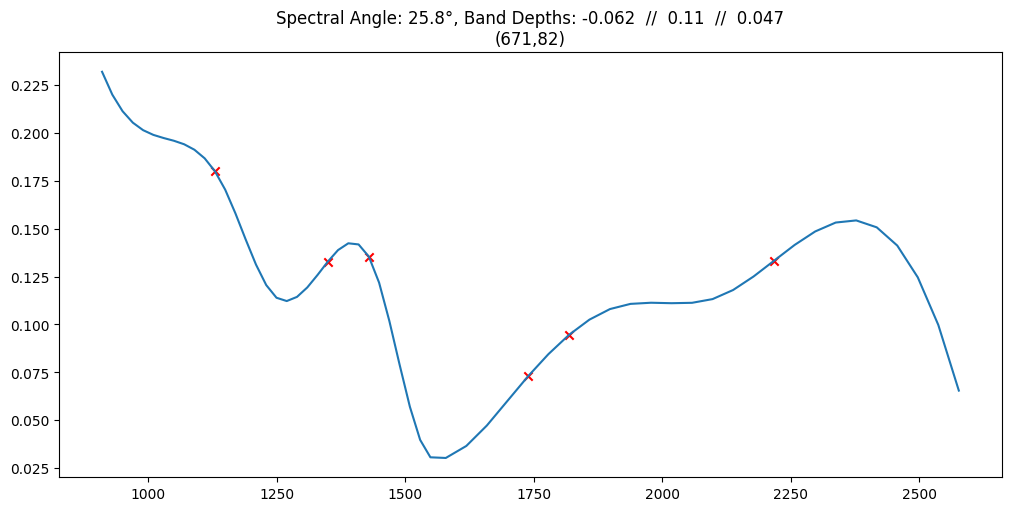

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tifffile as tf
import os

wvl = np.array(pd.read_csv('D:/Data/Ice_Pipeline_Out_6-14-23/bandInfo.csv').iloc[:,2])

water_detect_data = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-14-23/all_detections_30_withSPA.csv')
print (water_detect_data[['x','y','Stamp_Num']].loc[water_detect_data['Stamp_Num']==1].shape)

folder_path = 'D:/Data/Ice_Pipeline_Out_6-14-23'
bd_files = os.listdir(os.path.join(folder_path,'band_depth_maps'))
spa_files = os.listdir(os.path.join(folder_path,'spectral_angle_maps'))
smooth_files = os.listdir(os.path.join(folder_path,'rfl_smooth'))
smooth_files_norm = os.listdir(os.path.join(folder_path,'rfl_smooth_normalized'))

bd_im = tf.imread(os.path.join(folder_path,'band_depth_maps',bd_files[0]))
spa_im_raw = tf.imread(os.path.join(folder_path,'spectral_angle_maps',spa_files[0]))
smooth_im = tf.imread(os.path.join(folder_path,'rfl_smooth',smooth_files[0]))
smooth_im_norm = tf.imread(os.path.join(folder_path,'rfl_smooth_normalized',smooth_files_norm[0]))
spa_im=spa_im_raw

bd_bool = (np.isnan(bd_im[:,:,0])==0)#&(bd_im[:,:,0]>0)


spa_bool = spa_im<30.3

combo_bool = bd_bool*spa_bool
print ('1.',np.where(combo_bool==1))
print ([i for i in ((np.where(combo_bool==1)[0:2]))])

coord_list=[i for i in ((np.where(combo_bool==1)[0:2]))]
wvlList = [1130,1350,1420,1740,1820,2200]
n=0
for x,y in zip(*coord_list):
    fig,ax = plt.subplots(1,1,figsize=(10,5),layout='constrained')
    print (spa_im_raw[x,y])
    ax.plot(wvl,smooth_im[x,y,:])
    for w in wvlList:
        ind = np.where(abs(wvl-w)==abs(wvl-w).min())[0]
        plt_wvl = wvl[ind]
        ax.scatter(plt_wvl,smooth_im[x,y,ind],marker='x',color='red')

    ax.set_title(f'Spectral Angle: {spa_im_raw[x,y]:.1f}\u00B0, Band Depths: {"  //  ".join(str(i.round(3)) for i in bd_im[x,y,:])}\n({x},{y})')
    n+=1
    break

print (smooth_im_norm[671,82,:])


In [3]:
import tifffile

(3585, 304, 59)


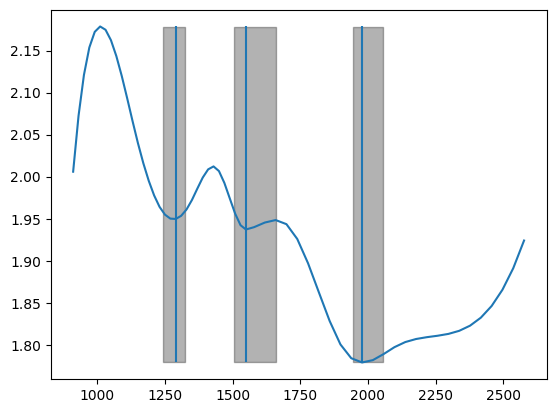

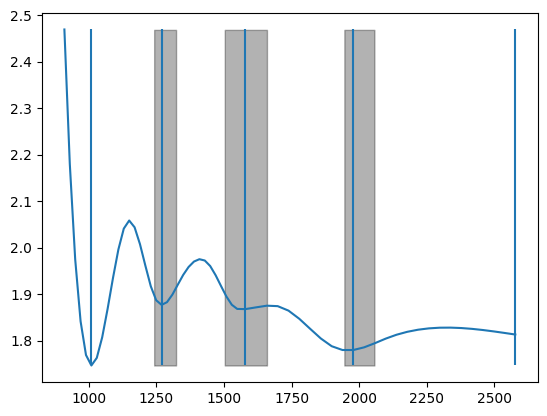

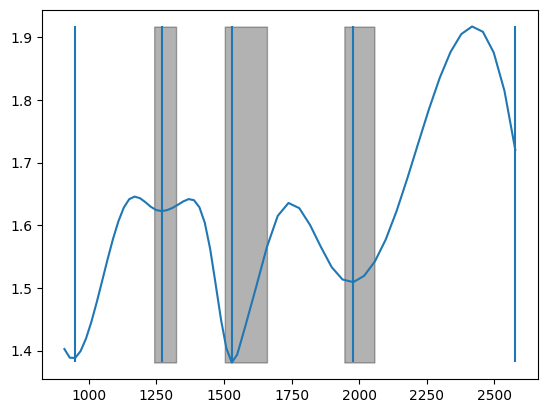

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
print (allband_array.shape)
df = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-2-23/bandInfo.csv')
wvl = df.iloc[:,2]
def plot_stuff(x,y):
    fig = plt.figure()
    test_spec = list(in_dict.values())[0][x,y,:]
    plt.plot(wvl,test_spec)
    plt.vlines(wvl[np.where(allband_array[x,y,:]==1)[0]],test_spec.min(),test_spec.max())
    plt.fill_betweenx(np.arange(test_spec.min(),test_spec.max(),0.001),1242,1323,color='k',alpha=0.3)
    plt.fill_betweenx(np.arange(test_spec.min(),test_spec.max(),0.001),1503,1659,color='k',alpha=0.3)
    plt.fill_betweenx(np.arange(test_spec.min(),test_spec.max(),0.001),1945,2056,color='k',alpha=0.3)
plot_stuff(0,98)
plot_stuff(0,101)
plot_stuff(3244,150)


44.855213019448456
45.507950938676636
45.507950938676636
44.855213019448456
43.236967102436815
43.989820821554176
43.989820821554176
40.87756225798143
50.25947602832627
50.25947602832627
40.87756225798143
43.989820821554176
43.179859392671574
49.27017355999539
43.78279355686042
50.25947602832627


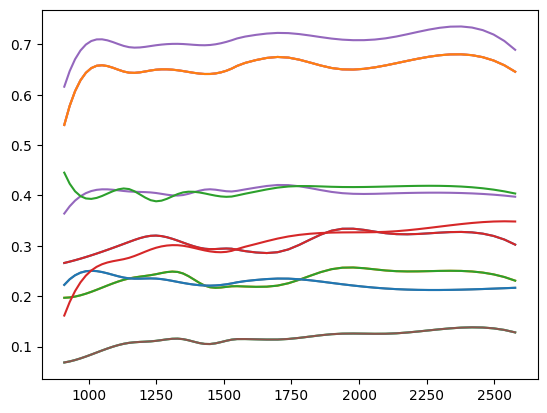

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from get_USGS_H2OFrost import get_USGS_H2OFrost
import numpy as np
df = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-2-23/sample_spectra.csv')
wvl_df = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-2-23/bandInfo.csv')
wvl = wvl_df.iloc[:,2]
_wvl,M = get_USGS_H2OFrost('D:/Data/USGS_Water_Ice')
for i in df.columns[1:]:
    I = np.array(df[i])
    plt.plot(wvl,I)
    #print (np.dot(I,M)/(np.linalg.norm(M)*np.linalg.norm(I)))
    print (180*(np.arccos(np.dot(df[i],M)/(np.linalg.norm(M)*np.linalg.norm(df[i])))/np.pi))

173, (0.02%)
(173, 59)


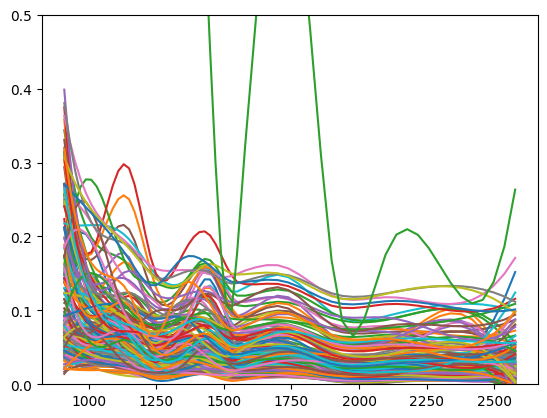

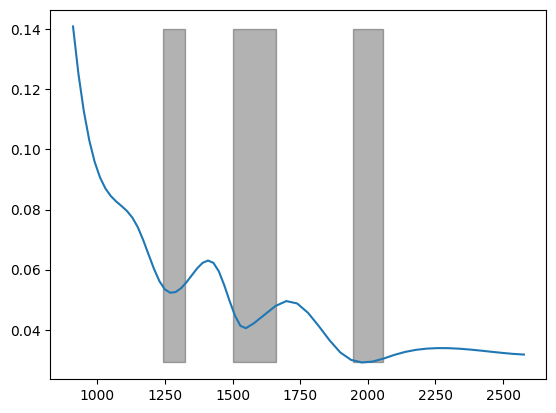

In [40]:
import tifffile as tf
smooth_im = tf.imread('D:/Data/Ice_Pipeline_Out_6-2-23/rfl_smooth/20090529t183825_smooth.tif')
df = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-2-23/detection_latlong.csv')
x,y = df['x'],df['y']
wvl_df = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-2-23/bandInfo.csv')
wvl = wvl_df.iloc[:,2]
_wvl,M = get_USGS_H2OFrost('D:/Data/USGS_Water_Ice')

avg_arr = np.zeros((0,59))

num = 0
for i,j in zip(x,y):
    I = smooth_im[i,j,:]
    plt.plot(wvl,I)
    #print (180*(np.arccos(np.dot(I,M)/(np.linalg.norm(M)*np.linalg.norm(I)))/np.pi))
    avg_arr = np.concatenate([avg_arr,I[np.newaxis,:]])
    num+=1
plt.ylim(0,0.5)
print (f'{num}, ({num/smooth_im[:,:,0].size:.2%})')
print (avg_arr.shape)
fig = plt.figure()
avg = np.mean(avg_arr,axis=0)
plt.plot(wvl,avg)
plt.fill_betweenx(np.arange(avg.min(),avg.max(),0.001),1242,1323,color='k',alpha=0.3)
plt.fill_betweenx(np.arange(avg.min(),avg.max(),0.001),1503,1659,color='k',alpha=0.3)
plt.fill_betweenx(np.arange(avg.min(),avg.max(),0.001),1945,2056,color='k',alpha=0.3)

(3333, 304, 2)
[[ 134676.5 -104529.2]
 [ 139184.5  -94104.5]
 [ 139466.2  -94668. ]
 [ 139748.   -92414. ]
 [ 140029.8  -92977.5]
 [ 140875.   -94104.5]
 [ 160034.  -171867.5]
 [ 199760.8 -207931.5]
 [ 202296.5 -203423.5]
 [ 204550.5 -212157.8]
 [ 207368.  -197506.8]]
2972 124 (3333, 304, 59)
2994 83 (3333, 304, 59)
2990 84 (3333, 304, 59)
2998 77 (3333, 304, 59)
2994 78 (3333, 304, 59)
2985 79 (3333, 304, 59)
2541 256 (3333, 304, 59)
2178 262 (3333, 304, 59)
2187 243 (3333, 304, 59)
2134 263 (3333, 304, 59)
2188 214 (3333, 304, 59)


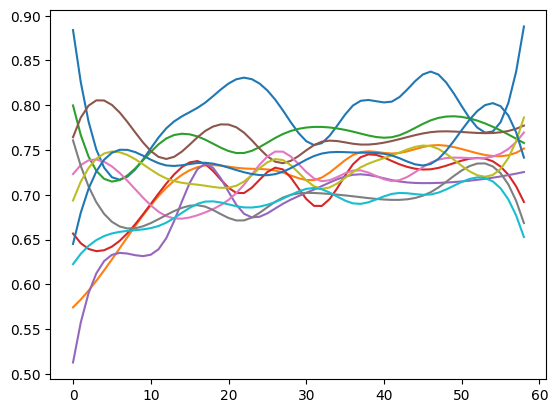

In [119]:
def stereo_project(lat:np.ndarray,long:np.ndarray)->np.ndarray:
    return np.array((2*1737400*np.tan(np.pi/4-np.pi*abs(lat/360))*np.sin(np.pi*long/180),\
            2*1737400*np.tan(np.pi/4-np.pi*abs(lat/360))*np.cos(np.pi*long/180)))
def stereo_project_float(lat:float,long:float)->tuple:
    return (2*1737400*np.tan(np.pi/4-np.pi*abs(lat/360))*np.sin(np.pi*long/180),\
            2*1737400*np.tan(np.pi/4-np.pi*abs(lat/360))*np.cos(np.pi*long/180))

smooth_im_backplane = tf.imread('D:/Data/Ice_Pipeline_Out_6-2-23/loc_cropped/m3g20090529t183825_loc_cropped.tif')
backplane_projected = np.moveaxis(stereo_project(smooth_im_backplane[:,:,1],smooth_im_backplane[:,:,0]),0,2)
print (backplane_projected.shape)

x_max,x_min,y_max,y_min = (backplane_projected[:,:,0].max(),backplane_projected[:,:,0].min(),backplane_projected[:,:,1].max(),backplane_projected[:,:,1].min())

with open('D:/Data/SP_IceLoc_280m.txt','r') as f:
    li_locations = f.readlines()
li_locations = [i[:-1] for i in li_locations]
li_locations = [i.split('\t') for i in li_locations]
li_locations = np.array(li_locations).astype(float)
li_locations_test = li_locations[np.where((li_locations[:,0]>x_min)&(li_locations[:,0]<x_max)&(li_locations[:,1]>y_min)&(li_locations[:,1]<y_max))]
print (li_locations_test)
fig = plt.figure()


prog,tot = 1,len(tuple(li_locations_test.T)[0])
mapped_coord_array = np.zeros((0,2))
for x,y in zip(*tuple(li_locations_test.T)):
    idx = (np.abs(backplane_projected[:,:,0]-x)+np.abs(backplane_projected[:,:,1]-y)).argmin()
    x_close,y_close = backplane_projected[:,:,0].flatten()[idx],backplane_projected[:,:,1].flatten()[idx]
    mapped_coord_array = np.concatenate([mapped_coord_array,np.array((x_close,y_close))[np.newaxis,:]])

for x,y in zip(mapped_coord_array[:,0],mapped_coord_array[:,1]):
    x_np,y_np = (np.where((backplane_projected[:,:,0]==x)&(backplane_projected[:,:,1]==y)))
    print (x_np[0],y_np[0],smooth_im.shape)
    plt.plot(smooth_im[x_np[0],y_np[0],:])


ORIG_MAX: 3.5693740844726562
ORIG_MIN: -0.11931402236223221

OBS_MAX: 164.74740600585938
OBS_MIN:26.795948028564453


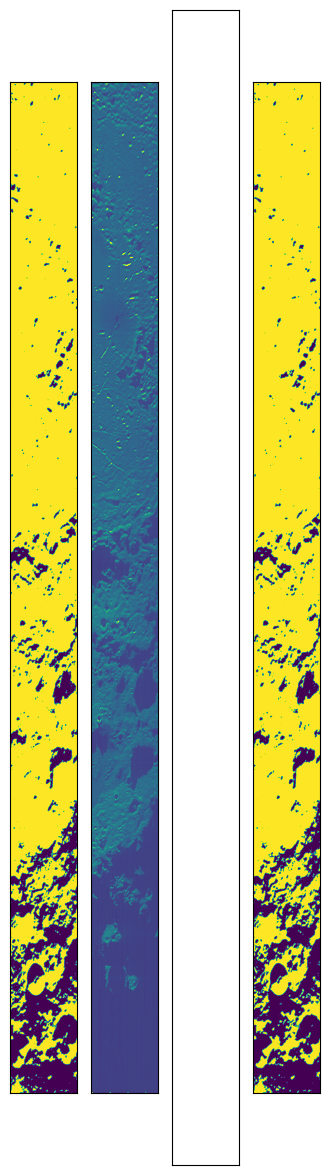

In [41]:
import os
import tifffile as tf
import numpy as np
import matplotlib.pyplot as plt

obs_im = tf.imread('D:/Data/Ice_Pipeline_Out_6-2-23/obs_cropped/m3g20090529t013507_obs_cropped.tif')
obs_im[:,:,-1] = 180*np.arccos(obs_im[:,:,-1])/np.pi
x,y = (np.where(obs_im[:,:,-1]>90))
bool_obs = np.ones((obs_im.shape[:2]))
bool_obs[x,y] = 0
og_im = tf.imread('D:/Data/Ice_Pipeline_Out_6-2-23/rfl_cropped/m3g20090529t013507_rfl_cropped.tif')

fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(4,15))
ax1.set_yticks([]),ax2.set_yticks([]),ax3.set_yticks([]),ax4.set_yticks([])
ax1.set_xticks([]),ax2.set_xticks([]),ax3.set_xticks([]),ax4.set_xticks([])
ax1.imshow(bool_obs)
ax2.imshow(og_im[:,:,0],vmax=0.5)

print (f'ORIG_MAX: {og_im[:,:,0].max()}\nORIG_MIN: {og_im[:,:,0].min()}\n')
print (f'OBS_MAX: {obs_im[:,:,-1].max()}\nOBS_MIN:{obs_im[:,:,-1].min()}')

bool_compare = tf.imread('D:/Data/Ice_Pipeline_Out_6-2-23/incidence_bright_bool_arrays/20090529t013507_inc_bright.tif')
ax3.plot()
ax4.imshow(bool_compare)

In [66]:
import cubic_spline_image as csi
from importlib import reload
reload(csi)
import pandas as pd
wvl = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-2-23/bandInfo.csv').iloc[:,2]
im_test = tf.imread('D:/Data/Ice_Pipeline_Out_6-2-23/rfl_cropped/m3g20090529t013507_rfl_cropped.tif')
avgWvl,avgSpecImage,smoothImage = csi.splineFit(im_test,5,wvl)

Applying spline along axis 2...


KeyboardInterrupt: 

In [41]:
wvl = np.array(pd.read_csv('D:/Data/Ice_Pipeline_Out_6-14-23/bandInfo.csv').iloc[:,2])
band1_indices = np.where((wvl>1242)&(wvl<1323))[0]
band2_indices = np.where((wvl>1503)&(wvl<1659))[0]
band3_indices = np.where((wvl>1945)&(wvl<2056))[0]

print (wvl[17])
print (band1_indices,band2_indices,band3_indices)

1249.49
[17 18 19 20] [30 31 32 33 34 35] [43 44]


(4814, 304, 59)
(588352, 59)
-9999.0

Bright Points:
(2442, 19)
(532, 194)


Shadow Points Points:
(3826, 83)
(1514, 287)




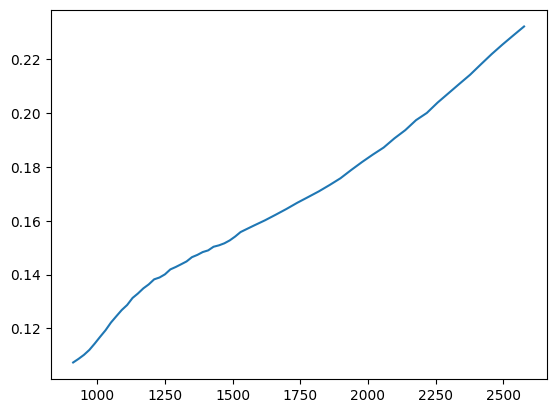

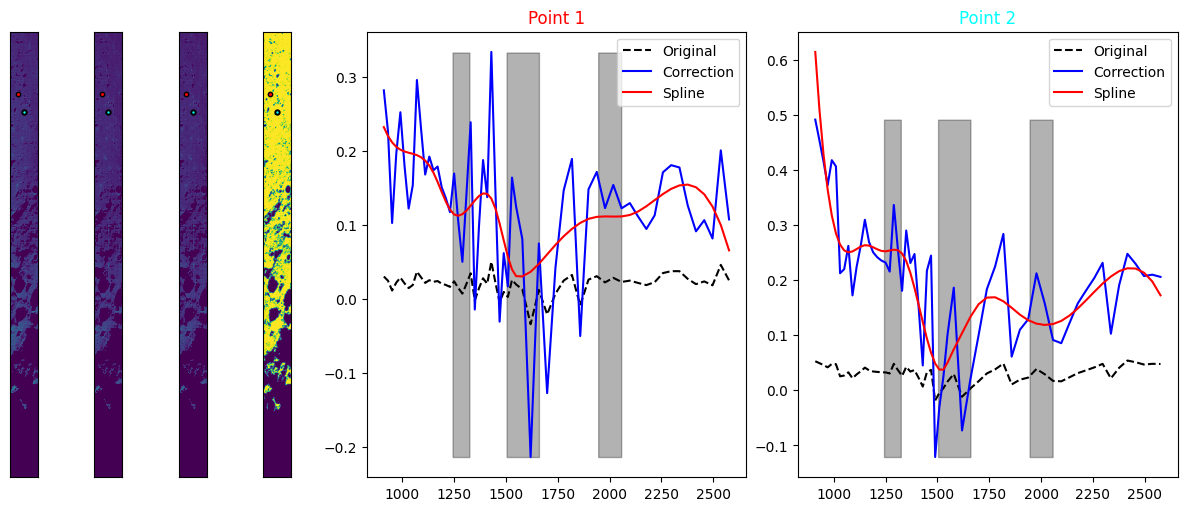

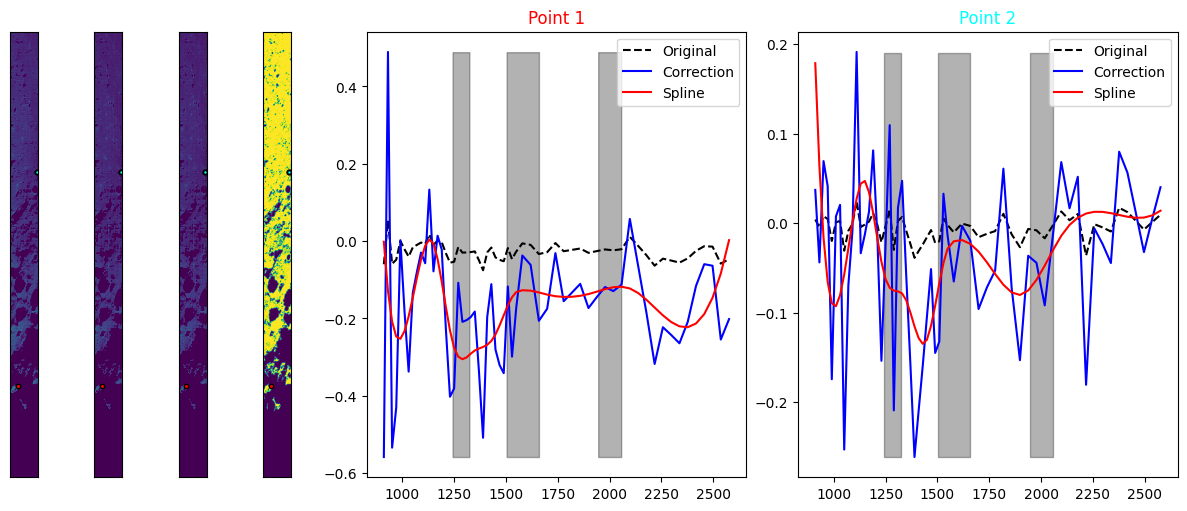

In [30]:
import tifffile as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy

wvl = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-14-23/bandInfo.csv').iloc[:,2]


im_id = '20090528t083319'
rfl_img = tf.imread(f'D:/Data/Ice_Pipeline_Out_6-14-23/rfl_cropped/m3g{im_id}_rfl_cropped.tif')
bool_array = tf.imread(f'D:/Data/Ice_Pipeline_Out_6-14-23/bright_bool_arrays/{im_id}_bright.tif')
R_BI = np.mean(np.load('D:/Data/Ice_Pipeline_Out_6-14-23/mosaic_stats_array.npy')[:,:,0],axis=0)
plt.plot(wvl,R_BI)
corrected_img = tf.imread(f'D:/Data/Ice_Pipeline_Out_6-14-23/rfl_correction/{im_id}_corrected.tif')
smooth_img = tf.imread(f'D:/Data/Ice_Pipeline_Out_6-14-23/rfl_smooth/{im_id}_smooth.tif')
rfl_img_real = copy.copy(rfl_img)
shaded_regions = rfl_img[np.where(bool_array==-9999)]
print (rfl_img.shape)
print (shaded_regions.shape)
shaded_regions_corrected = shaded_regions/R_BI
rfl_img[np.where(bool_array==-9999)] = shaded_regions_corrected

def get_spec(x,y):
    if x>rfl_img.shape[1] or y>rfl_img.shape[0]:
        raise ValueError(f'The point ({y},{x}) is not on the image of size {(rfl_img.shape[:2])}!')
    fig,axList = plt.subplots(1,6,figsize=(12,5),width_ratios=[1,1,1,1,5,5],constrained_layout=True)
    for num,ax in enumerate(axList):
        if num==4:
            break
        ax.set_yticks([])
        ax.set_xticks([])
    axList[0].imshow(rfl_img_real[:,:,0],vmax=rfl_img_real[:,:,0].max()*0.1,vmin=0.05)
    axList[1].imshow(rfl_img[:,:,0],vmax=rfl_img[:,:,0].max()*0.1,vmin=0.05)
    axList[2].imshow(corrected_img[:,:,0],vmax=corrected_img[:,:,0].max()*0.1,vmin=0.05)
    axList[3].imshow(bool_array)
    axList[4].plot(wvl,rfl_img_real[y,x,:],label='Original',ls='--',color='k')
    axList[4].plot(wvl,corrected_img[y,x,:],label='Correction',color='blue')
    axList[4].plot(wvl,smooth_img[y,x,:],label='Spline',color='red')
    for i,j in zip([1242,1503,1945],[1323,1659,2056]): 
        axList[4].fill_betweenx(np.arange(corrected_img[y,x,:].min(),corrected_img[y,x,:].max(),0.001),i,j,color='k',alpha=0.3)
    axList[4].set_title('Point 1',color='red')
    axList[4].legend()
    axList[0].scatter(x,y,marker='o',color='red',edgecolors='k',s=10)
    axList[1].scatter(x,y,marker='o',color='red',edgecolors='k',s=10)
    axList[2].scatter(x,y,marker='o',color='red',edgecolors='k',s=10)
    axList[3].scatter(x,y,marker='o',color='red',edgecolors='k',s=10)

    return fig,axList

def add_point(axList,x,y):
    axList[5].plot(wvl,rfl_img_real[y,x,:],label='Original',ls='--',color='k')
    axList[5].plot(wvl,corrected_img[y,x,:],label='Correction',color='blue')
    axList[5].plot(wvl,smooth_img[y,x,:],label='Spline',color='red')
    axList[5].set_title('Point 2',color='cyan')
    axList[5].legend()
    axList[0].scatter(x,y,marker='o',color='cyan',edgecolors='black',linewidth=1.4,s=10)
    axList[1].scatter(x,y,marker='o',color='cyan',edgecolors='black',linewidth=1.4,s=10)
    axList[2].scatter(x,y,marker='o',color='cyan',edgecolors='black',linewidth=1.4,s=10)
    axList[3].scatter(x,y,marker='o',color='cyan',edgecolors='black',linewidth=1.4,s=10)
    for i,j in zip([1242,1503,1945],[1323,1659,2056]): 
        axList[5].fill_betweenx(np.arange(corrected_img[y,x,:].min(),corrected_img[y,x,:].max(),0.001),i,j,color='k',alpha=0.3)

print (bool_array.min())
shade_coords = [(i,j) for i,j in zip(*(np.where(bool_array==-9999)))]
bright_coords = [(i,j) for i,j in zip(*(np.where(bool_array==1)))]
rand_ind1 = np.random.choice(range(len(shade_coords)))
rand_ind2 = np.random.choice(range(len(shade_coords)))
rand_ind1_bright = np.random.choice(range(len(bright_coords)))
rand_ind2_bright = np.random.choice(range(len(bright_coords)))
print ()
fig1,ax1 = get_spec(82,671)
add_point(ax1,152,864)
fig2,ax2 = get_spec(*reversed(shade_coords[rand_ind1]))
add_point(ax2,*reversed(shade_coords[rand_ind2]))
print(f'Bright Points:\n{bright_coords[rand_ind1_bright]}\n{bright_coords[rand_ind2_bright]}\n\n')
print(f'Shadow Points Points:\n{shade_coords[rand_ind1]}\n{shade_coords[rand_ind2]}\n\n')

29.631166


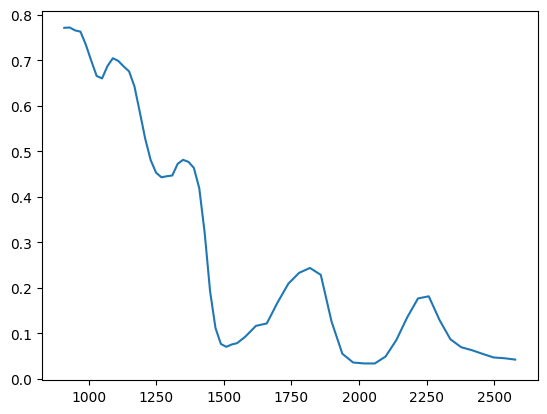

In [12]:
spec_ang = tf.imread('D:/Data/Ice_Pipeline_Out_6-14-23/spectral_angle_maps/20090528t083319_SAM.tif')
import get_USGS_H2OFrost
from importlib import reload
reload(get_USGS_H2OFrost)
from get_USGS_H2OFrost import get_USGS_H2OFrost
_wvl,usgs_spec = get_USGS_H2OFrost('D:/Data/USGS_Water_Ice',wvl)
print (spec_ang[147,15])
#plt.plot(wvl,smooth_img[147,15,:])
plt.plot(wvl,usgs_spec)

896 896
166.68477 16.820442
1443
166.68477 16.820442
0 1


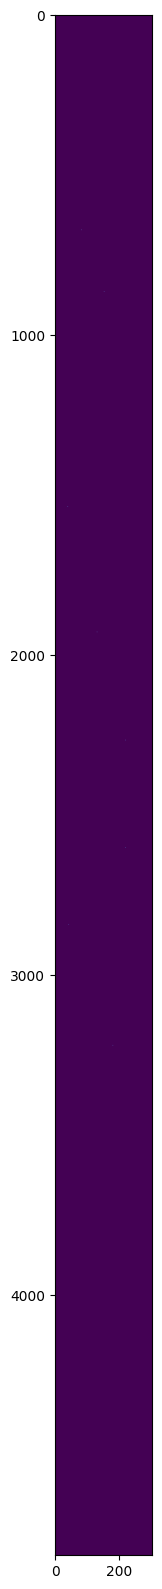

In [27]:
import tifffile as tf
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

im = tf.imread('D:/Data/Ice_Pipeline_Out_6-14-23/spectral_angle_maps/20090528t083319_SAM.tif')
water_loc = np.array(pd.read_csv('D:/Data/Ice_Pipeline_Out_6-14-23/water_locations/20090528t083319.csv').iloc[:,-2:]).astype(int)
x,y = (water_loc.T)

print (len(x),len(y))

bool_array = np.zeros(im.shape).astype(int)
bool_array[x,y] = 1

print (im.max(),im.min())
print (len(np.where(im<30)[0]))
bool_array[np.where(im>30)]=0
print (im.max(),im.min())
fig = plt.figure(figsize=(5,20))
plt.imshow(bool_array)

print (bool_array.min(),bool_array.max())

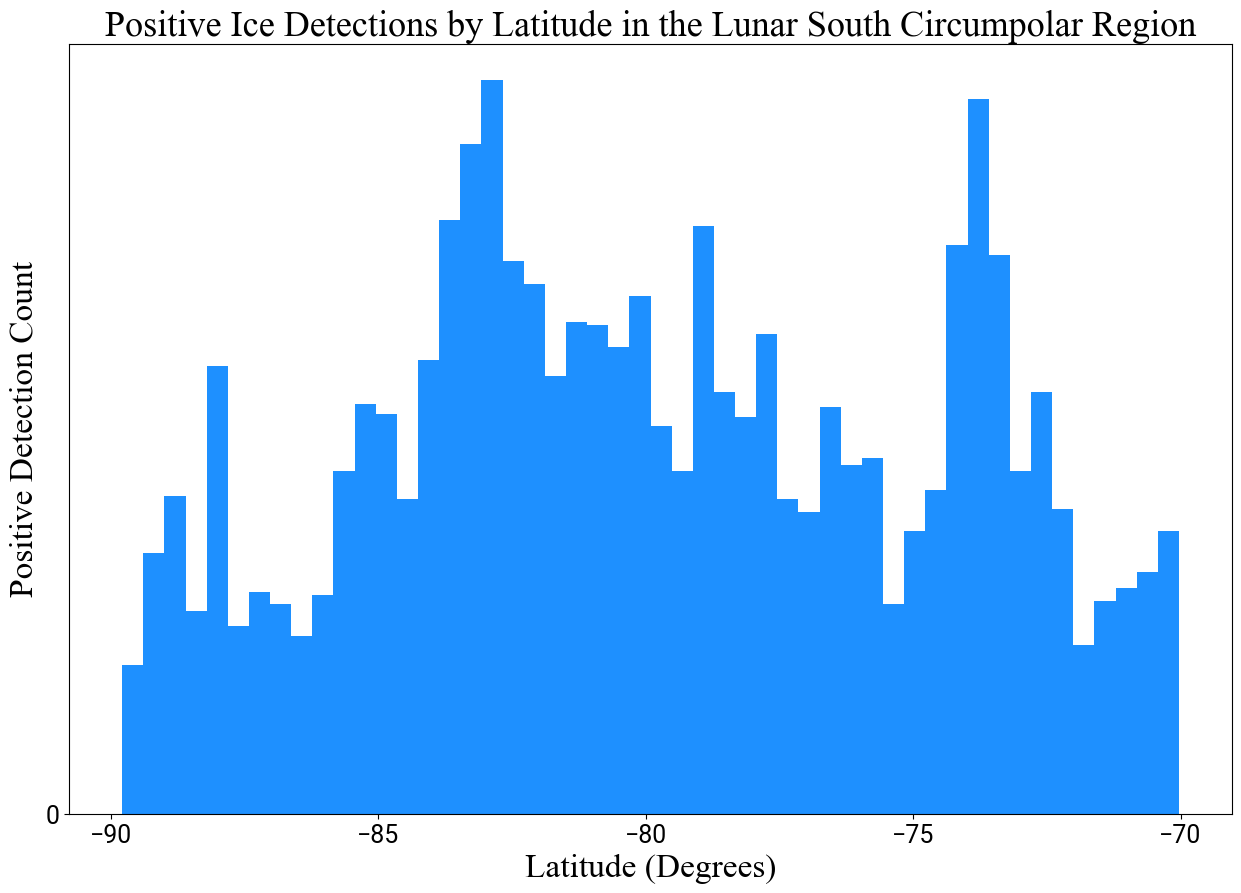

In [58]:
'''
Creating SCP Region Histogram of Water Detections vs. Latitude
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import os
import os.path as path

# pd.set_option('display.max_rows',None)

# flist = matplotlib.font_manager.get_font_names()
# flist.sort()
# fig = plt.figure()
# def factor(n):
#     return [(i,n//i) for i in range(1,int(n**0.5)+1) if n%i==0]

# print (factor(len(flist)))

# fig,ax = plt.subplots(1,1,figsize=(25,30))
# x,y = np.meshgrid(range(28),range(7))
# ax.set_xlim(-0.1,7)
# ax.set_ylim(-1,28.1)
# for i,j,font in zip(x.flatten(),y.flatten(),flist):
#     plt.text(j,i,font,fontdict={'fontname':font,'fontsize':14})

# plt.savefig('C:/Users/zvig/OneDrive - University of Iowa/Desktop/ALL_FONTS.png')



label_font = {'fontname':'Times New Roman','fontsize':24}
tick_font = {'fontname':'Roboto','fontsize':18}
title_font = {'fontname':'Times New Roman','fontsize':26}

all_detect = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-14-23/one_pct_band_depth_detections.csv')
fig = plt.figure(figsize=(15,10))
plt.hist(all_detect['Latitude'],50,color='dodgerblue')
plt.xlabel('Latitude (Degrees)',label_font)
plt.ylabel('Positive Detection Count',label_font)
plt.title('Positive Ice Detections by Latitude in the Lunar South Circumpolar Region',title_font)
plt.xticks(range(-90,-65,5),**tick_font)
plt.yticks(range(0,500,500),**tick_font)

plt.savefig('D:/Ice_Locations_Figures/Ice_Locations_onepct_bd_Histogram.png',dpi=350)

In [30]:
'''
Getting average water spectra of all ice detections
'''
import tifffile as tf
import numpy as np
import pandas as pd
import os
import os.path as path
import time

all_detect = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-14-23/one_pct_band_depth_detections.csv')

with open('D:/Data/Ice_Pipeline_Out_6-14-23/stampNames.txt') as f:
    stampNames = f.readlines()
stampNames = [i[:-2] for i in stampNames]
smooth_image_folder_path = 'D:/Data/Ice_Pipeline_Out_6-14-23/rfl_smooth'
raw_image_folder_path = 'D:/Data/Ice_Pipeline_Out_6-14-23/rfl_cropped'
corrected_image_folder_path = 'D:/Data/Ice_Pipeline_Out_6-14-23/rfl_correction'
if 'smooth_images' not in locals():
    print ('Fetching smoothed images from CPU...')
    smooth_images = [tf.imread(path.join(smooth_image_folder_path,i)) for i in os.listdir(smooth_image_folder_path)]
if 'raw_images' not in locals():
    print ('Fetching raw images from CPU...')
    raw_images = [tf.imread(path.join(raw_image_folder_path,i)) for i in os.listdir(raw_image_folder_path)]
if 'corrected_images' not in locals():
    print ('Fetching corrected images from CPU')
    corrected_images = [tf.imread(path.join(corrected_image_folder_path,i)) for i in os.listdir(corrected_image_folder_path)]

print (f'{len(smooth_images)} Smoothed Images and {len(corrected_images)} Corrected Images have been loaded!')

all_spectra_array = np.zeros((0,59))
all_raw_array = np.zeros((0,59))
for i in range(0,len(smooth_images)):
    x,y = (np.array(all_detect.loc[all_detect['Stamp_Num']==i+1][['x','y']]).astype(int).T)
    detections = smooth_images[i][x,y]
    detections_raw = corrected_images[i][x,y]
    all_spectra_array = np.concatenate([all_spectra_array,detections])
    all_raw_array = np.concatenate([all_raw_array,detections_raw])

print (all_spectra_array.shape)
print (all_raw_array.shape)

Fetching raw images from CPU...
98 Smoothed Images and 98 Corrected Images have been loaded!
(5984, 59)
(5984, 59)


0.02429445 87


'20090812t195113'

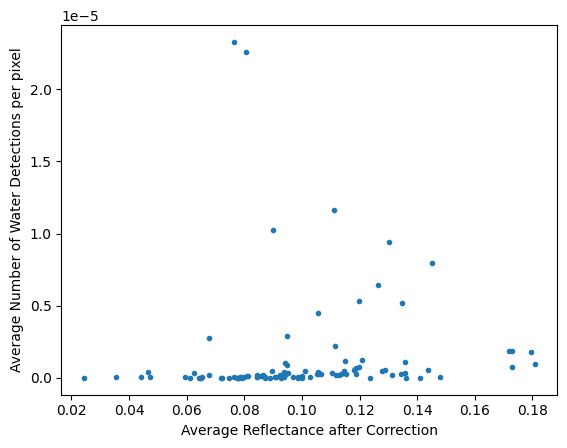

In [56]:
import matplotlib.pyplot as plt
# avgrfl_raw = [i.mean() for i in raw_images]
# num_detected_per_pix = [i/j.size for i,j in zip(num_detected,raw_images)]
plt.scatter(avgrfl_raw,num_detected_per_pix,marker='.')
plt.ylabel('Average Number of Water Detections per pixel')
plt.xlabel('Average Reflectance after Correction')

print (min(avgrfl_raw),avgrfl_raw.index(min(avgrfl_raw)))
stampNames[avgrfl_raw.index(min(avgrfl_raw))]


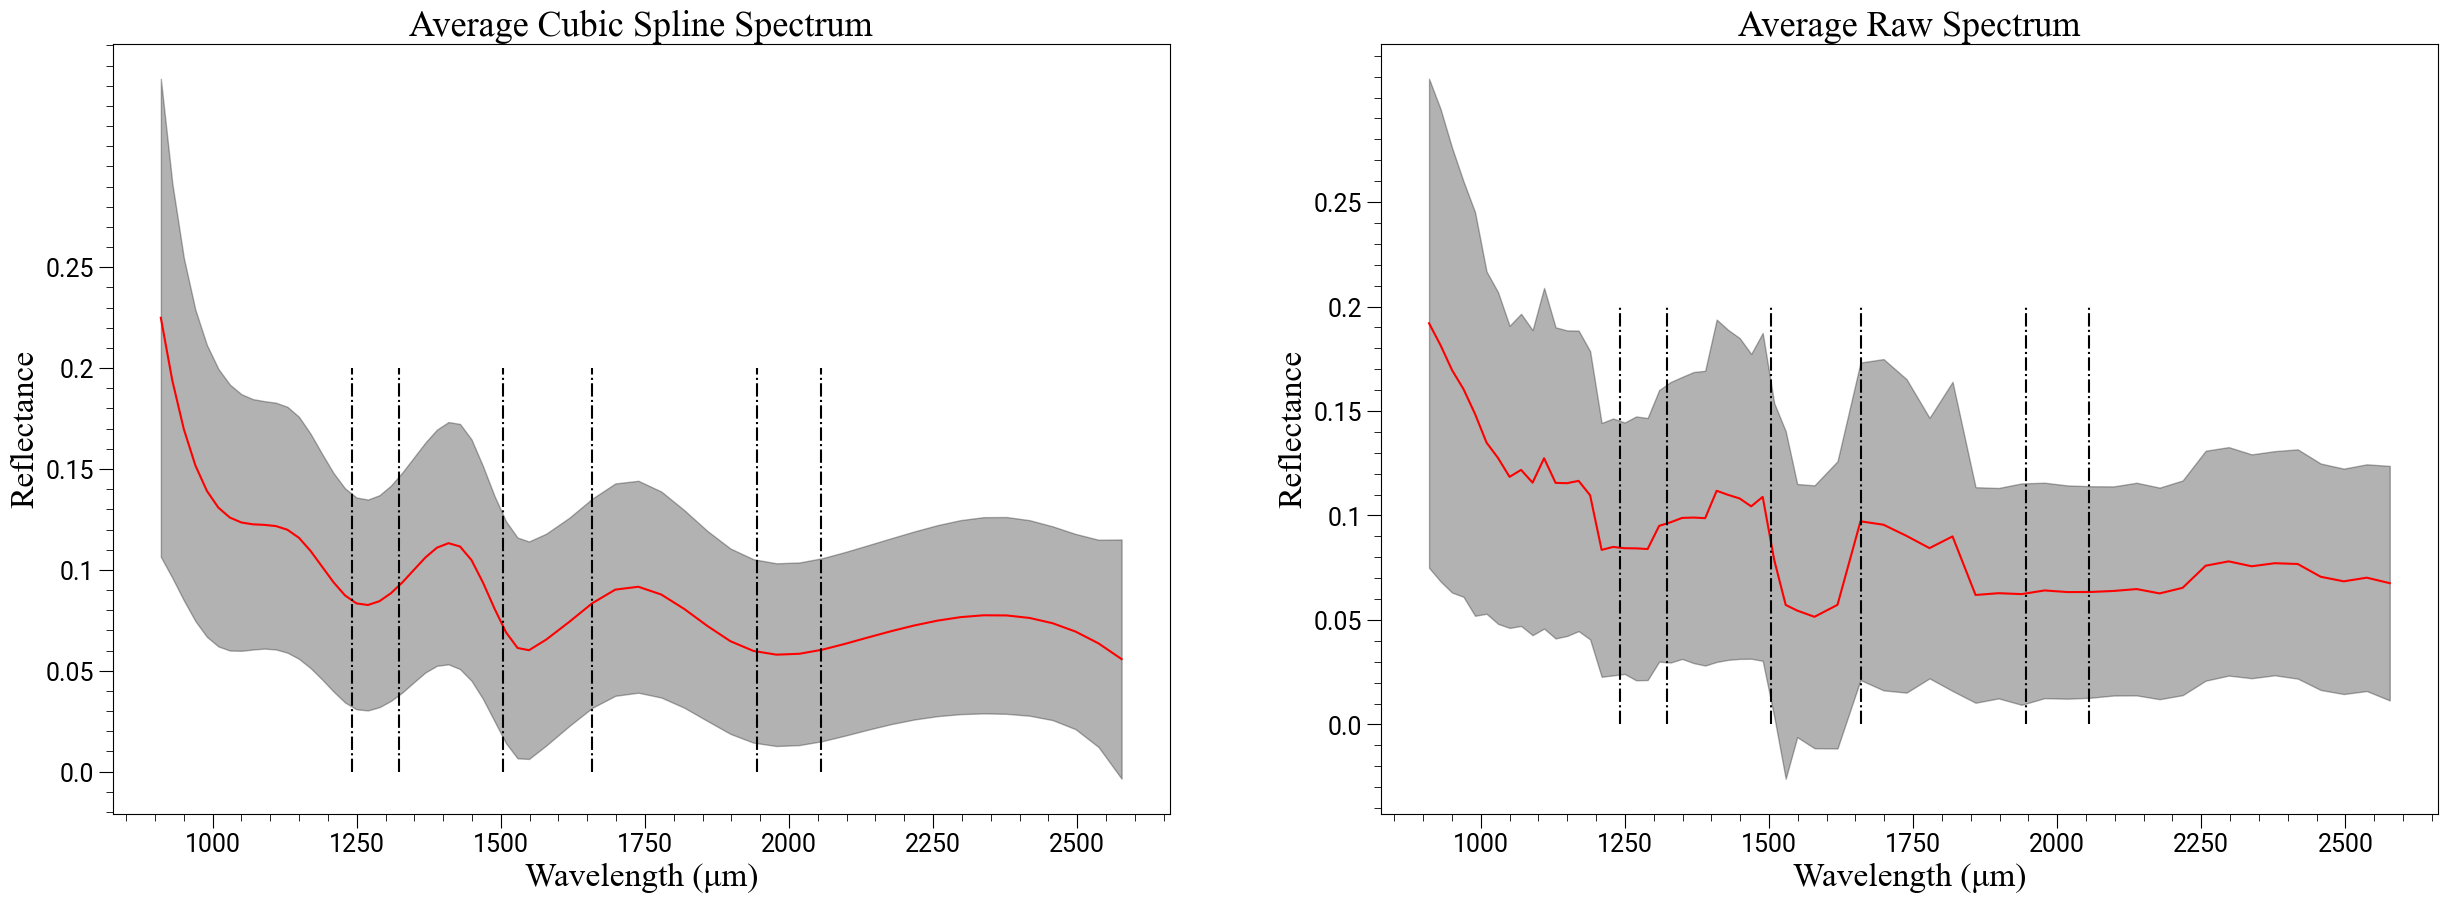

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import pandas as pd
import numpy as np
from get_USGS_H2OFrost import get_USGS_H2OFrost

label_font = {'fontname':'Times New Roman','fontsize':24}
tick_font = {'fontname':'Roboto','fontsize':18}
title_font = {'fontname':'Times New Roman','fontsize':26}

wvl = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-14-23/bandInfo.csv').iloc[:,2]
avg_smooth_spec = np.mean(all_spectra_array,axis=0)
std_smooth_spec = np.std(all_spectra_array,axis=0)
avg_raw_spec = np.mean(all_raw_array,axis=0)
std_raw_spec = np.std(all_raw_array,axis=0)

usgs_spec = get_USGS_H2OFrost()

fig,axList = plt.subplots(1,2,figsize=(30,10))
axList[0].plot(wvl,avg_smooth_spec,color='red')
axList[0].fill_between(wvl,avg_smooth_spec-std_smooth_spec,avg_smooth_spec+std_smooth_spec,color='k',alpha=0.3)
axList[0].set_title('Average Cubic Spline Spectrum',title_font)
axList[0].set_yticks(np.arange(0,0.3,0.05),np.around(np.arange(0,0.3,0.05),2),**tick_font)
axList[0].yaxis.set_minor_locator(tck.MultipleLocator(0.01))
for lo,hi in zip([1242,1503,1945],[1323,1659,2056]):
    axList[0].vlines([lo,hi],0,0.2,color='k',ls='dashdot')

axList[1].plot(wvl,avg_raw_spec,color='red')
axList[1].fill_between(wvl,avg_raw_spec-std_raw_spec,avg_raw_spec+std_raw_spec,color='k',alpha=0.3)
axList[1].set_title('Average Raw Spectrum',title_font)
axList[1].set_yticks(np.arange(0,0.3,0.05),np.around(np.arange(0,0.3,0.05),2),**tick_font)
axList[1].yaxis.set_minor_locator(tck.MultipleLocator(0.01))
for lo,hi in zip([1242,1503,1945],[1323,1659,2056]):
    axList[1].vlines([lo,hi],0,0.2,color='k',ls='dashdot')

for ax in axList:
    ax.set_xticks(range(1000,2750,250),range(1000,2750,250),**tick_font)
    ax.set_xlabel('Wavelength (\u03Bcm)',label_font)
    ax.set_ylabel('Reflectance',label_font)
    ax.xaxis.set_minor_locator(tck.MultipleLocator(50))
    ax.tick_params(length=10)
    ax.tick_params('both',which='minor',length=5)

plt.savefig('D:/Ice_Locations_Figures/Mean_Spec_onepct_bd.png',dpi=400)
    

In [1]:
import os
import os.path as path
import tifffile as tf
smooth_image_folder_path = 'D:/Data/Ice_Pipeline_Out_6-14-23/rfl_smooth'
raw_image_folder_path = 'D:/Data/Ice_Pipeline_Out_6-14-23/rfl_correction'
print ('Fetching smoothed images from CPU...')
smooth_images = [tf.imread(path.join(smooth_image_folder_path,i)) for i in os.listdir(smooth_image_folder_path)]
print ('Fetching raw images from CPU...')
corrected_images = [tf.imread(path.join(raw_image_folder_path,i)) for i in os.listdir(raw_image_folder_path)]

Fetching smoothed images from CPU...
Fetching raw images from CPU...


(2688,)


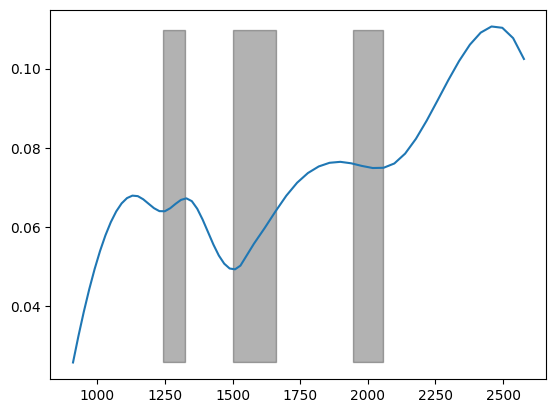

In [11]:
import tifffile as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

wvl = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-14-23/bandInfo.csv').iloc[:,2]
bd_im = tf.imread('D:/Data/Ice_Pipeline_Out_6-14-23/band_depth_maps/20090528t083319_BD_map.tif')
good_pix_np_loc = (np.where(np.isnan(bd_im[:,:,0])==0))
good_pix = bd_im[np.where(np.isnan(bd_im)==0)]
smooth_im = smooth_images[0]
print (good_pix.shape)
x,y = good_pix_np_loc[0][0],good_pix_np_loc[1][0]


plt.plot(wvl,smooth_im[x,y,:])
plt.fill_betweenx(np.arange(smooth_im[x,y,:].min(),smooth_im[x,y,:].max(),0.001),1242,1323,color='k',alpha=0.3)
plt.fill_betweenx(np.arange(smooth_im[x,y,:].min(),smooth_im[x,y,:].max(),0.001),1503,1659,color='k',alpha=0.3)
plt.fill_betweenx(np.arange(smooth_im[x,y,:].min(),smooth_im[x,y,:].max(),0.001),1945,2056,color='k',alpha=0.3)


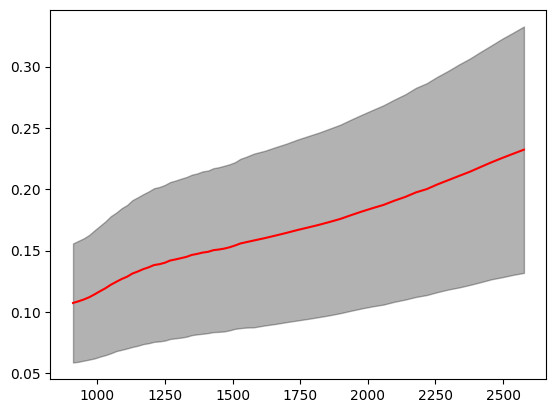

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
arr = np.load('D:/Data/Ice_Pipeline_Out_7-19-23/mosaic_stats_array.npy')
wvl = pd.read_csv('D:/Data/Ice_Pipeline_Out_7-19-23/bandInfo.csv').iloc[:,2]
avg = np.mean(arr[:,:,0],axis=0)
std = np.mean(arr[:,:,1],axis=0)
plt.plot(wvl,avg,color='red')
plt.fill_between(wvl,avg-std,avg+std,alpha=0.3,color='k')

0.008763846


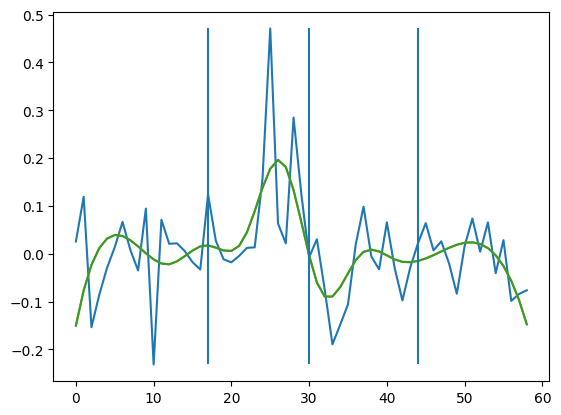

In [49]:
import numpy as np
import tifffile as tf
import matplotlib.pyplot as plt
correction_im = tf.imread('D:/Data/Ice_Pipeline_Out_8-7-23/rfl_correction/20090528t083319.tif')
smooth_im = tf.imread('D:/Data/Ice_Pipeline_Out_8-7-23/rfl_smooth/20090528t083319.tif')
smooth_im2 = tf.imread('D:/Data/Ice_Pipeline_Out_8-7-23/rfl_smooth_complete/20090528t083319.tif')

def plot(x,y):
    plt.plot(correction_im[x,y,:])
    plt.plot(smooth_im[x,y,:])
    plt.plot(smooth_im2[x,y,:])
    plt.vlines([17,30,44],correction_im[x,y].min(),correction_im[x,y].max())
    print (np.mean(correction_im[x,y,:]))
plot(465,65)

In [46]:
def myfunc(bool_array,*args):
    true_coords = np.where(bool_array==True)
    array = np.array([i[true_coords] for i in args])
    return array

bool_array = np.array([[False,True,False,False]]*4)
print (bool_array)
print (np.where(bool_array==True))
arr1 = np.array([[1,2,3,4],[1,2,3,4]]*2)
arr2 = np.array([[1,2,3,4],[1,2,3,4]]*2)
arr3 = np.array([[1,2,3,4],[1,2,3,4]]*2)
print (arr1,'\n\n',arr2)
myfunc(bool_array,arr1,arr2,arr3).shape

[[False  True False False]
 [False  True False False]
 [False  True False False]
 [False  True False False]]
(array([0, 1, 2, 3], dtype=int64), array([1, 1, 1, 1], dtype=int64))
[[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]] 

 [[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]


(3, 4)

In [1]:
import os
import numpy as np

stat_arr = np.load()


In [2]:
import os
import tifffile as tf

ice_pipe = 'D:/Data/Ice_Pipeline_Out_8-7-23'

rfl_smooth_paths = [os.path.join(ice_pipe,'rfl_smooth',i) for i in os.listdir(os.path.join(ice_pipe,'rfl_smooth'))]
rfl_correction_paths = [os.path.join(ice_pipe,'rfl_correction',i) for i in os.listdir(os.path.join(ice_pipe,'rfl_correction'))]

rfl_smooth = [tf.imread(i) for i in rfl_smooth_paths]
rfl_correction = [tf.imread(i) for i in rfl_correction_paths]

ValueError: operands could not be broadcast together with shapes (4999,) (5000,) 

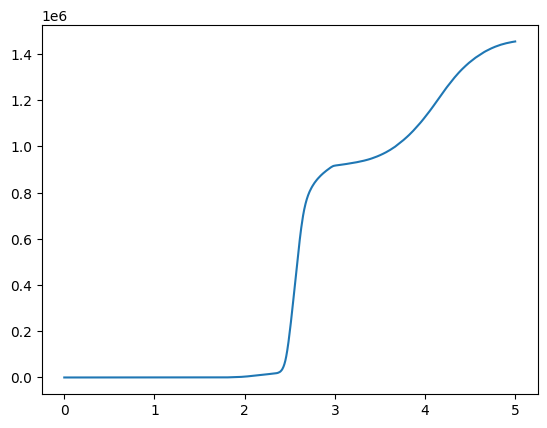

In [36]:
import os
import tifffile as tf
import matplotlib.pyplot as plt
import numpy as np

ice_pipe = 'D:/Data/Ice_Pipeline_Out_8-7-23'

euclidian_distance_maps = [tf.imread(os.path.join(ice_pipe,'euclidian_distance_values',i))\
                            for i in os.listdir(os.path.join(ice_pipe,'euclidian_distance_values'))]


def get_euc_dist_thresh_vals(THRESH):
    # for i,j in zip(euclidian_distance_maps,rfl_correction):
    #     fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(10,10))
    #     ax1.hist(i.flatten(),bins=200)
    #     ax1.vlines(THRESH,0,400000,color='red',ls='--')
    #     ax2.imshow(i<THRESH)
    #     ax3.imshow(np.mean(j,axis=2))
    #     break

    return len(np.where(euclidian_distance_maps[0]<THRESH)[0])

add_vals = []
ind_list = []
for i in np.arange(0,5,0.001):
    add_vals.append(get_euc_dist_thresh_vals(i))
    ind_list.append(i)

plt.plot(ind_list,add_vals)

def find_diff(in_list):
    in_arr = np.array(in_list)
    in_arr_offset = np.append(in_arr,in_arr[0])
    in_arr_offset = np.delete(in_arr,0)
    diff_arr = in_arr_offset-in_arr
    diff_arr = np.delete(diff_arr,-1)
    diff_arr = np.insert(diff_arr,0,diff_arr[0])
    diff_arr.insert(0,diff_arr[0])
    
    return diff_arr

diff = find_diff(add_vals)
plt.plot(ind_list,diff)

thresh = ind_list[np.where(np.array(diff)==np.array(diff).min())[0][0]]

plt.vlines(thresh,min(add_vals),max(add_vals),color='red',ls='--')

In [34]:
myarr_og = np.array([0,1,2,3,4])

myarr = np.append(myarr_og,myarr_og[0])
myarr = np.delete(myarr,0)

print (myarr_og)
print (myarr)
print (myarr-myarr_og)

[0 1 2 3 4]
[1 2 3 4 0]
[ 1  1  1  1 -4]
